In [1]:
!pip install torch_geometric
!pip install ace_tools_open

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.3 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear

In [3]:
from torch_geometric.data import HeteroData

data = torch.load("/content/drive/MyDrive/AIT/ML/Project/personalized_medical_recommendation/preprocessing/processed_graph.pt", weights_only=False)

## Plot Graph

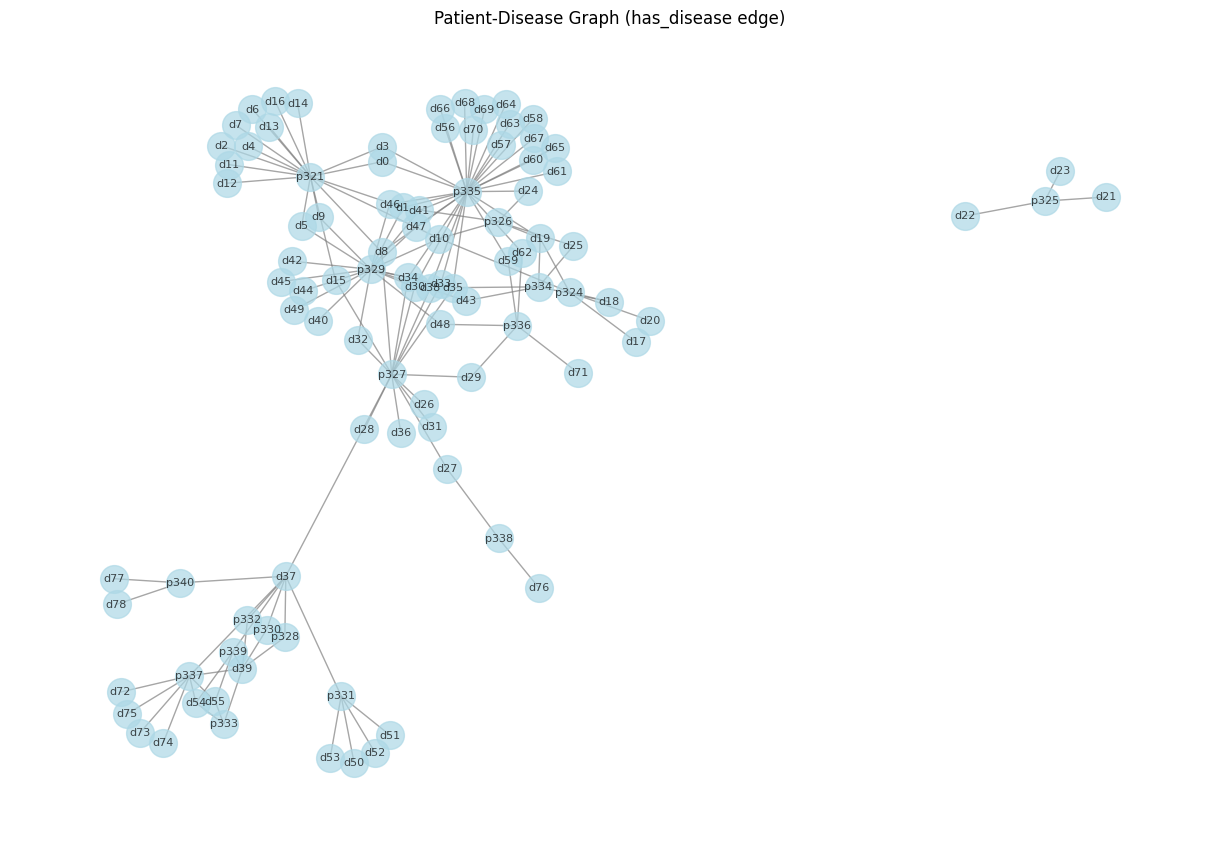

In [4]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Select edge index and create a new NetworkX graph
edge_index = data["patient", "has_disease", "disease"].edge_index

# Convert PyTorch tensor to list of tuples
edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))

# Step 2: Initialize a directed or undirected NetworkX graph
subset_edges = edges[:200]
G = nx.Graph()
G.add_edges_from(subset_edges)

# Optional: relabel nodes for clarity (e.g., distinguish patients and diseases)
mapping = {}
for u in edge_index[0].unique().tolist():
    mapping[u] = f"p{u}"
for v in edge_index[1].unique().tolist():
    mapping[v] = f"d{v}"

G = nx.relabel_nodes(G, mapping)

# Step 3: Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_size=400, font_size=8, alpha=0.7, node_color="lightblue", edge_color="gray")
plt.title("Patient-Disease Graph (has_disease edge)")
plt.show()

## Modeling

In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

class HeteroSAGELinkPredictor(nn.Module):
    def __init__(self, metadata, output_dims, hidden_channels=64, out_channels=32):
        super().__init__()

        # Message passing layers
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.conv2 = HeteroConv({
            edge_type: SAGEConv((hidden_channels, hidden_channels), out_channels)
            for edge_type in metadata[1]
        }, aggr='sum')

        # NEW: MLP that maps raw patient features → same space as GNN
        self.patient_encoder = nn.Sequential(
            nn.Linear(44, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )

        # Decoder: combines patient, medication, and optional context features
        self.decoder = nn.Sequential(
            nn.Linear(out_channels * 5, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, 1)
        )

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

    def encode_patient(self, patient_features):
        return self.patient_encoder(patient_features)

    def decode(
        self,
        z_patient,
        z_medication,
        z_disease,
        z_procedure,
        z_lab,
        edge_index,
        disease_ids=None,
        procedure_ids=None,
        lab_ids=None,
    ):
        src, dst = edge_index

        # Default to zero vectors if ids are None (i.e., for inference without all context)
        def get_context_embeddings(z, ids):
            if ids is None:
                return torch.zeros_like(z_patient[src])
            return z[ids]

        disease_emb = get_context_embeddings(z_disease, disease_ids)
        proc_emb    = get_context_embeddings(z_procedure, procedure_ids)
        lab_emb     = get_context_embeddings(z_lab, lab_ids)

        # Concatenate all embeddings
        combined = torch.cat([
            z_patient[src],
            z_medication[dst],
            disease_emb,
            proc_emb,
            lab_emb
        ], dim=1)

        return self.decoder(combined).squeeze()

In [7]:
from torch_geometric.nn import HeteroConv, SAGEConv

data = data.to(device)

with torch.no_grad():
    temp_conv1 = HeteroConv({
        edge_type: SAGEConv((-1, -1), out_channels=64)
        for edge_type in data.edge_types
    }, aggr='sum').to(device)

    temp_output = temp_conv1(data.x_dict, data.edge_index_dict)
    output_dims = {node_type: feat.shape[1] for node_type, feat in temp_output.items()}

## Train Test Split

In [8]:
# Instantiate the model using SAGEConv
model = HeteroSAGELinkPredictor(data.metadata(), output_dims=output_dims).to(device)

# Split 'prescribed' edge into train, val, and test
edge_index = data["patient", "prescribed", "medication"].edge_index
num_edges = edge_index.size(1)
perm = torch.randperm(num_edges)

# 80% train, 10% val, 10% test
train_idx = perm[:int(0.8 * num_edges)]
val_idx   = perm[int(0.8 * num_edges):int(0.9 * num_edges)]
test_idx  = perm[int(0.9 * num_edges):]

# Construct edge splits
train_pos_edge_index = edge_index[:, train_idx]
val_pos_edge_index   = edge_index[:, val_idx]
test_pos_edge_index  = edge_index[:, test_idx]

In [9]:
from collections import defaultdict
import torch

def build_first_association_map(src_nodes, dst_nodes):
    """Build a mapping from patient to first associated node (disease/procedure/lab)."""
    assoc_map = {}
    for src, dst in zip(src_nodes.tolist(), dst_nodes.tolist()):
        if src not in assoc_map:
            assoc_map[src] = dst
    return assoc_map

def get_first_associated_node(assoc_map, patient_ids, default_val=-1):
    """Return first associated node for each patient in patient_ids."""
    return torch.tensor(
        [assoc_map.get(pid.item(), default_val) for pid in patient_ids],
        dtype=torch.long
    )

In [10]:
# Build once before training
edge_pd = data["patient", "has_disease", "disease"].edge_index
edge_pp = data["patient", "underwent", "procedure"].edge_index
edge_pl = data["patient", "has_lab", "lab"].edge_index

disease_map = build_first_association_map(edge_pd[0], edge_pd[1])
procedure_map = build_first_association_map(edge_pp[0], edge_pp[1])
lab_map = build_first_association_map(edge_pl[0], edge_pl[1])

# During each epoch (or once if fixed)
train_diseases = get_first_associated_node(disease_map, train_pos_edge_index[0])
train_procs = get_first_associated_node(procedure_map, train_pos_edge_index[0])
train_labs = get_first_associated_node(lab_map, train_pos_edge_index[0])

## Create Trainer

In [11]:
from torch_geometric.utils import negative_sampling

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

from torch_geometric.utils import negative_sampling
import torch.nn.functional as F

def train(
    model, data, train_pos_edge_index,
    disease_map, procedure_map, lab_map,
    optimizer, device
):
    model.train()
    optimizer.zero_grad()

    # Forward pass: get all embeddings
    z_dict = model(data.x_dict, data.edge_index_dict)

    # Replace patient node embeddings with outputs from the patient_encoder (MLP)
    patient_features = data["patient"].x.to(device)
    z_dict["patient"] = model.encode_patient(patient_features)

    # Positive samples
    pos_patients = train_pos_edge_index[0]
    pos_diseases = get_first_associated_node(disease_map, pos_patients)
    pos_procs    = get_first_associated_node(procedure_map, pos_patients)
    pos_labs     = get_first_associated_node(lab_map, pos_patients)

    pos_pred = model.decode(
        z_patient     = z_dict["patient"],
        z_medication  = z_dict["medication"],
        z_disease     = z_dict["disease"],
        z_procedure   = z_dict["procedure"],
        z_lab         = z_dict["lab"],
        edge_index    = train_pos_edge_index,
        disease_ids   = pos_diseases,
        procedure_ids = pos_procs,
        lab_ids       = pos_labs
    )

    # Negative samples
    neg_edge_index = negative_sampling(
        edge_index=train_pos_edge_index,
        num_nodes=(data["patient"].num_nodes, data["medication"].num_nodes),
        num_neg_samples=train_pos_edge_index.size(1),
        method='sparse'
    )
    neg_patients = neg_edge_index[0]

    neg_diseases = get_first_associated_node(disease_map, neg_patients)
    neg_procs    = get_first_associated_node(procedure_map, neg_patients)
    neg_labs     = get_first_associated_node(lab_map, neg_patients)

    neg_pred = model.decode(
        z_patient     = z_dict["patient"],
        z_medication  = z_dict["medication"],
        z_disease     = z_dict["disease"],
        z_procedure   = z_dict["procedure"],
        z_lab         = z_dict["lab"],
        edge_index    = neg_edge_index,
        disease_ids   = neg_diseases,
        procedure_ids = neg_procs,
        lab_ids       = neg_labs
    )

    # Combine predictions and labels
    pred = torch.cat([pos_pred, neg_pred])
    labels = torch.cat([
        torch.ones(pos_pred.size(0)),
        torch.zeros(neg_pred.size(0))
    ]).to(device)

    # Loss and optimization
    loss = F.binary_cross_entropy_with_logits(pred, labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

def evaluate(model, data, pos_edge_index, disease_map, procedure_map, lab_map, device):
    model.eval()
    with torch.no_grad():
        z_dict = model(data.x_dict, data.edge_index_dict)

        # Step 2: Replace patient embeddings using the patient_encoder MLP
        patient_features = data["patient"].x.to(device)
        z_dict["patient"] = model.encode_patient(patient_features)  # <-- Encoder used here

        pos_patients = pos_edge_index[0]

        # Lookup associated nodes for positive samples
        pos_diseases = get_first_associated_node(disease_map, pos_patients)
        pos_procs    = get_first_associated_node(procedure_map, pos_patients)
        pos_labs     = get_first_associated_node(lab_map, pos_patients)

        # Positive predictions
        pos_pred = model.decode(
            z_patient     = z_dict["patient"],
            z_medication  = z_dict["medication"],
            z_disease     = z_dict["disease"],
            z_procedure   = z_dict["procedure"],
            z_lab         = z_dict["lab"],
            edge_index    = pos_edge_index,
            disease_ids   = pos_diseases,
            procedure_ids = pos_procs,
            lab_ids       = pos_labs
        ).sigmoid()

        # === Negative samples ===
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=(data["patient"].num_nodes, data["medication"].num_nodes),
            num_neg_samples=pos_edge_index.size(1),
            method='sparse'
        )
        neg_patients = neg_edge_index[0]

        # Lookup for negatives
        neg_diseases = get_first_associated_node(disease_map, neg_patients)
        neg_procs    = get_first_associated_node(procedure_map, neg_patients)
        neg_labs     = get_first_associated_node(lab_map, neg_patients)

        # Negative predictions
        neg_pred = model.decode(
            z_patient     = z_dict["patient"],
            z_medication  = z_dict["medication"],
            z_disease     = z_dict["disease"],
            z_procedure   = z_dict["procedure"],
            z_lab         = z_dict["lab"],
            edge_index    = neg_edge_index,
            disease_ids   = neg_diseases,
            procedure_ids = neg_procs,
            lab_ids       = neg_labs
        ).sigmoid()

        # === Metrics ===
        preds = torch.cat([pos_pred, neg_pred])
        labels = torch.cat([
            torch.ones(pos_pred.size(0)),
            torch.zeros(neg_pred.size(0))
        ]).to(device)

        auc = roc_auc_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu().round())
        acc = accuracy_score(labels.cpu(), preds.cpu().round())
        return auc, f1, acc

## Training

In [ ]:
best_acc = 0
best_auc = 0
best_f1 = 0

ckpt_path = "/content/drive/MyDrive/AIT/ML/Project/personalized_medical_recommendation/checkpoints"

for epoch in range(1, 501):
    loss = train(model, data, train_pos_edge_index.to(device), disease_map, procedure_map, lab_map, optimizer, device)
    print(f"Epoch {epoch:03d} | Loss: {loss:.4f}")

    if epoch % 10 == 0:
        val_auc, val_f1, val_acc = evaluate(model, data, val_pos_edge_index.to(device), disease_map, procedure_map, lab_map, device)
        print(f"\nVal AUC: {val_auc:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")

        # Save best models
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(ckpt_path, "best_model_acc.pt"))
            print("✅ Saved new best model based on Accuracy!")

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), os.path.join(ckpt_path, "best_model_auc.pt"))
            print("✅ Saved new best model based on ROC AUC!")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), os.path.join(ckpt_path, "best_model_f1.pt"))
            print("✅ Saved new best model based on F1 Score!\n")

Epoch 001 | Loss: 0.6977
Epoch 002 | Loss: 0.6886
Epoch 003 | Loss: 0.6763
Epoch 004 | Loss: 0.6576
Epoch 005 | Loss: 0.6311
Epoch 006 | Loss: 0.5936
Epoch 007 | Loss: 0.5481
Epoch 008 | Loss: 0.5035
Epoch 009 | Loss: 0.4675
Epoch 010 | Loss: 0.4499

Val AUC: 0.8801 | Val F1: 0.7984 | Val Acc: 0.7953
✅ Saved new best model based on Accuracy!
✅ Saved new best model based on ROC AUC!
✅ Saved new best model based on F1 Score!

Epoch 011 | Loss: 0.4496
Epoch 012 | Loss: 0.4452
Epoch 013 | Loss: 0.4172
Epoch 014 | Loss: 0.4088
Epoch 015 | Loss: 0.3833
Epoch 016 | Loss: 0.3774
Epoch 017 | Loss: 0.3613
Epoch 018 | Loss: 0.3601
Epoch 019 | Loss: 0.3489
Epoch 020 | Loss: 0.3480

Val AUC: 0.9307 | Val F1: 0.8627 | Val Acc: 0.8599
✅ Saved new best model based on Accuracy!
✅ Saved new best model based on ROC AUC!
✅ Saved new best model based on F1 Score!

Epoch 021 | Loss: 0.3362
Epoch 022 | Loss: 0.3338
Epoch 023 | Loss: 0.3226
Epoch 024 | Loss: 0.3186
Epoch 025 | Loss: 0.3090
Epoch 026 | Loss: 0

## Evaluation

In [ ]:
# Instantiate the model again with correct metadata and output dims
model = HeteroSAGELinkPredictor(data.metadata(), output_dims=output_dims).to(device)

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(ckpt_path, "best_model_acc.pt")))
model.eval()  # Set to eval mode

In [ ]:
# Move test edges to device
test_pos_edge_index = test_pos_edge_index.to(device)

# Evaluate the model
test_auc, test_f1, test_acc = evaluate(model, data, test_pos_edge_index, disease_map, procedure_map, lab_map, device)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
torch.save(model, os.path.join(ckpt_path, "best_model_whole.pt"))